In [65]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

transform = transforms.Compose(
    [
        transforms.Resize((128, 128)),  # Resize all images to 128x128
        transforms.ToTensor(),  # Convert PIL to tensor
        transforms.Normalize(
            [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]  # Normalize RGB channels
        ),
    ]
)
DATA_DIR = "/kaggle/input/museum/Training"

full_dataset = datasets.ImageFolder(root=DATA_DIR, transform=transform)
print(full_dataset.class_to_idx)
class_names = full_dataset.classes
print("Class names:", class_names)

train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_dataset, val_dataset = random_split(full_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)

images, labels = next(iter(train_loader))
print(f"Sample batch shape: {images.shape}, Labels: {labels}")

Using device: cuda
{'museum-indoor': 0, 'museum-outdoor': 1}
Class names: ['museum-indoor', 'museum-outdoor']
Sample batch shape: torch.Size([32, 3, 128, 128]), Labels: tensor([1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
        0, 0, 0, 1, 1, 1, 0, 0])


In [66]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CNNClassifier(nn.Module):
    def __init__(self, num_convs=3, use_pooling=True):
        super(CNNClassifier, self).__init__()
        layers = []
        in_channels = 3
        out_channels_list = [16, 32, 64, 128]
        self.use_pooling = use_pooling

        for i in range(num_convs):
            out_channels = out_channels_list[i]
            layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
            layers.append(nn.ReLU())
            if use_pooling:
                layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            in_channels = out_channels

        self.conv = nn.Sequential(*layers)

        if use_pooling:
            self.flatten_size = {1: 16*64*64, 2: 32*32*32, 3: 64*16*16, 4: 128*8*8}[num_convs]
        else:
            self.flatten_size = {1: 16*128*128, 2: 32*128*128, 3: 64*128*128, 4: 128*128*128}[num_convs]

        self.fc1 = nn.Linear(self.flatten_size, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, self.flatten_size)
        x = F.relu(self.fc1(x))
        return self.fc2(x)

In [67]:
# from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
# import torch.nn.functional as F

# def train_and_evaluate(num_convs=3, lr=0.001, batch_size=32, epochs=5, use_pooling=True):
#     train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
#     val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

#     model = CNNClassifier(num_convs=num_convs, use_pooling=use_pooling).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr)

#     for epoch in range(epochs):
#         model.train()
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()

#     # Evaluate on training set
#     model.eval()
#     y_true_train, y_pred_train = [], []
#     train_loss_total = 0.0
    
#     with torch.no_grad():
#         for images, labels in train_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = F.cross_entropy(outputs, labels)
#             train_loss_total += loss.item() * images.size(0)
        
#             _, preds = torch.max(outputs, 1)
#             y_true_train.extend(labels.cpu().numpy())
#             y_pred_train.extend(preds.cpu().numpy())
            
#     avg_train_loss = train_loss_total / len(train_loader.dataset)
    
#     # Evaluate on validation set
#     y_true_val, y_pred_val = [], []
#     val_loss_total = 0.0
    
#     with torch.no_grad():
#         for images, labels in val_loader:
#             images, labels = images.to(device), labels.to(device)
#             outputs = model(images)
#             loss = F.cross_entropy(outputs, labels)
#             val_loss_total += loss.item() * images.size(0)
#             _, preds = torch.max(outputs, 1)
#             y_true_val.extend(labels.cpu().numpy())
#             y_pred_val.extend(preds.cpu().numpy())
            
#     avg_val_loss = val_loss_total / len(val_loader.dataset)

#     metrics = {
#         "Train Accuracy": round(accuracy_score(y_true_train, y_pred_train), 4),
#         "Val Accuracy": round(accuracy_score(y_true_val, y_pred_val), 4),
#         "Precision": round(precision_score(y_true_val, y_pred_val, average='binary'), 4),
#         "Recall": round(recall_score(y_true_val, y_pred_val, average='binary'), 4),
#         "F1-Score": round(f1_score(y_true_val, y_pred_val, average='binary'), 4),
#         "Train Loss": round(avg_train_loss, 4),
#         "Val Loss": round(avg_val_loss, 4)
#     }

#     return metrics

In [71]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import torch.nn.functional as F

def train_and_evaluate(num_convs=3, lr=0.001, batch_size=32, epochs=5, use_pooling=True):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    model = CNNClassifier(num_convs=num_convs, use_pooling=use_pooling).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_accuracies, val_accuracies = [], []
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Training
        model.train()
        train_loss_total = 0.0
        y_true_train, y_pred_train = [], []

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss_total += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            y_true_train.extend(labels.cpu().numpy())
            y_pred_train.extend(preds.cpu().numpy())

        avg_train_loss = train_loss_total / len(train_loader.dataset)
        train_accuracy = accuracy_score(y_true_train, y_pred_train)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation
        model.eval()
        val_loss_total = 0.0
        y_true_val, y_pred_val = [], []

        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = F.cross_entropy(outputs, labels)
                val_loss_total += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                y_true_val.extend(labels.cpu().numpy())
                y_pred_val.extend(preds.cpu().numpy())

        avg_val_loss = val_loss_total / len(val_loader.dataset)
        val_accuracy = accuracy_score(y_true_val, y_pred_val)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

    
    precision = precision_score(y_true_val, y_pred_val, average='binary')
    recall = recall_score(y_true_val, y_pred_val, average='binary')
    f1 = f1_score(y_true_val, y_pred_val, average='binary')

    # Print classification metrics
    print(f"\nEvaluation Metrics:")
    print(f"Accuracy:  {val_accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")

    # Plot confusion matrix
    class_names = ['indoor', 'outdoor']
    cm = confusion_matrix(y_true_val, y_pred_val)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")
    plt.show()
    
    # Final epoch metrics
    final_metrics = {
        "Train Accuracy": round(train_accuracies[-1], 4),
        "Val Accuracy": round(val_accuracies[-1], 4),
        "Precision": round(precision, 4),
        "Recall": round(recall, 4),
        "F1-Score": round(f1, 4),
        "Train Loss": round(train_losses[-1], 4),
        "Val Loss": round(val_losses[-1], 4),
        # Add per-epoch tracking for plots
        "Train Acc Epochs": train_accuracies,
        "Val Acc Epochs": val_accuracies,
        "Train Loss Epochs": train_losses,
        "Val Loss Epochs": val_losses,
    }

    return final_metrics, model


Running Experiment: Baseline

Evaluation Metrics:
Accuracy:  0.9150
Precision: 0.9242
Recall:    0.9038
F1 Score:  0.9139


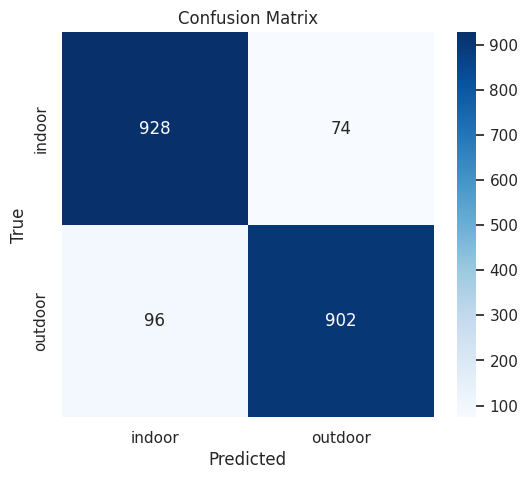


Running Experiment: Less Conv

Evaluation Metrics:
Accuracy:  0.9075
Precision: 0.9169
Recall:    0.8958
F1 Score:  0.9062


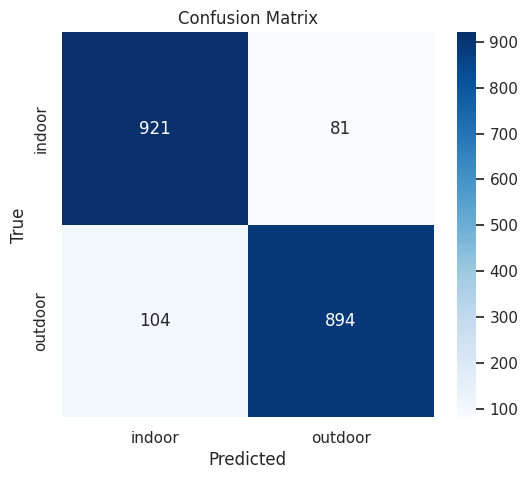


Running Experiment: Small LR

Evaluation Metrics:
Accuracy:  0.9140
Precision: 0.9311
Recall:    0.8938
F1 Score:  0.9121


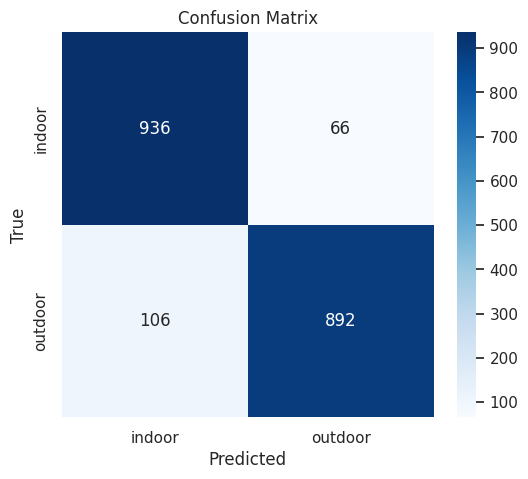


Running Experiment: Big Batch

Evaluation Metrics:
Accuracy:  0.9075
Precision: 0.9212
Recall:    0.8908
F1 Score:  0.9058


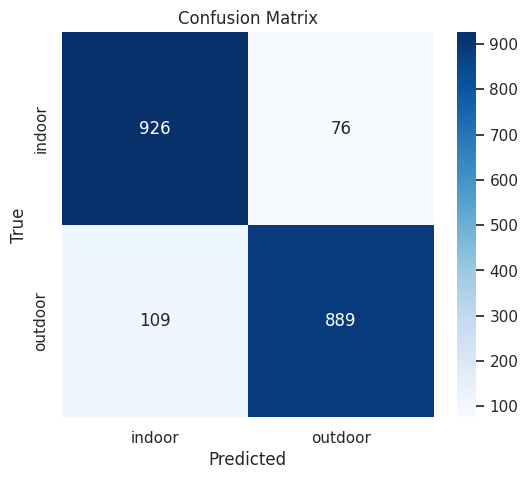


Running Experiment: More Conv

Evaluation Metrics:
Accuracy:  0.9155
Precision: 0.9481
Recall:    0.8788
F1 Score:  0.9121


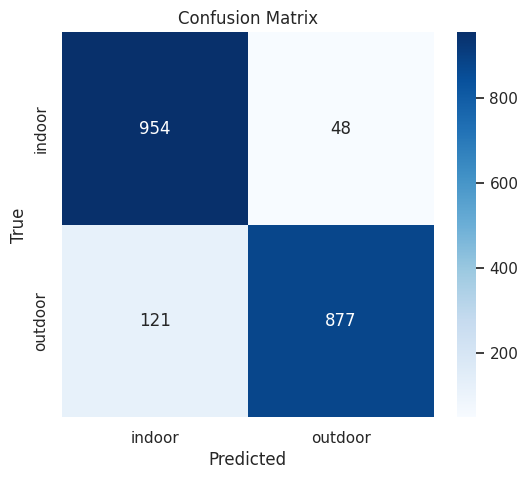


Running Experiment: No Pooling

Evaluation Metrics:
Accuracy:  0.8830
Precision: 0.9302
Recall:    0.8277
F1 Score:  0.8759


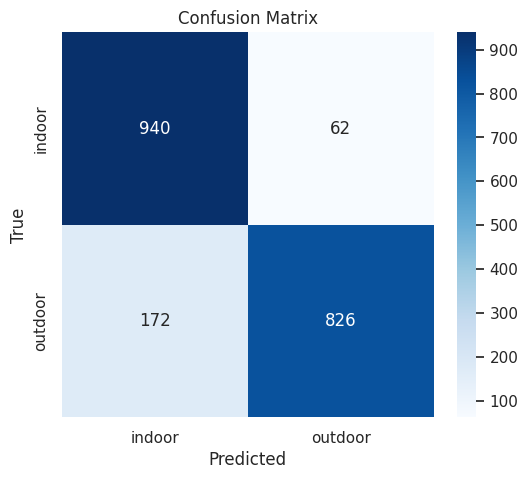


Best model saved: best_model_More Conv.pt with Val Accuracy = 0.9155


In [72]:
experiments = [
    {"id": "Baseline", "num_convs": 3, "lr": 0.001, "batch_size": 32, "use_pooling": True},
    {"id": "Less Conv", "num_convs": 2, "lr": 0.001, "batch_size": 32, "use_pooling": True},
    {"id": "Small LR", "num_convs": 3, "lr": 0.0005, "batch_size": 32, "use_pooling": True},
    {"id": "Big Batch", "num_convs": 3, "lr": 0.001, "batch_size": 64, "use_pooling": True},
    {"id": "More Conv", "num_convs": 4, "lr": 0.001, "batch_size": 32, "use_pooling": True},
    {"id": "No Pooling", "num_convs": 3, "lr": 0.001, "batch_size": 32, "use_pooling": False},
]

results = []
best_val_acc = 0.0
best_model = None
best_experiment_id = None

for exp in experiments:
    print(f"\nRunning Experiment: {exp['id']}")
    
    metrics, model = train_and_evaluate(
        num_convs=exp["num_convs"],
        lr=exp["lr"],
        batch_size=exp["batch_size"],
        use_pooling=exp["use_pooling"],
    )
    metrics.update(
        {
            "ID": exp["id"],
            "Conv Layers": exp["num_convs"],
            "Learning Rate": exp["lr"],
            "Batch Size": exp["batch_size"],
            "Pooling": "Yes" if exp["use_pooling"] else "No",
        }
    )
    
    results.append(metrics)
    if metrics["Val Accuracy"] > best_val_acc:
        best_val_acc = metrics["Val Accuracy"]
        best_model = model
        best_experiment_id = exp["id"]

# Save the best model overall
if best_model:
    torch.save(best_model, f"best_model_{best_experiment_id}.pt")
    print(f"\nBest model saved: best_model_{best_experiment_id}.pt with Val Accuracy = {best_val_acc:.4f}")






In [73]:
import pandas as pd
df_results = pd.DataFrame(results)

print("\nFinal Experiment Results (Training + Validation):")
df_results=df_results[
        [
            "ID",
            "Pooling",
            "Conv Layers",
            "Learning Rate",
            "Batch Size",
            "Train Accuracy",
            "Train Loss",
            "Val Accuracy",
            "Val Loss",
            "Precision",
            "Recall",
            "F1-Score",
        ]
    ]
print(df_results.to_string(index=False))

# Find best model by accuracy
best_model = df_results.loc[df_results["Val Accuracy"].idxmax()]
print("\nBest Model Based on Validation Accuracy:")
print(best_model)

best_model_path = "/kaggle/working/best_cnn.pth"
torch.save(best_model, best_model_path)


Final Experiment Results (Training + Validation):
        ID Pooling  Conv Layers  Learning Rate  Batch Size  Train Accuracy  Train Loss  Val Accuracy  Val Loss  Precision  Recall  F1-Score
  Baseline     Yes            3         0.0010          32          0.9469      0.1466        0.9150    0.2353     0.9242  0.9038    0.9139
 Less Conv     Yes            2         0.0010          32          0.9599      0.1148        0.9075    0.2700     0.9169  0.8958    0.9062
  Small LR     Yes            3         0.0005          32          0.9380      0.1634        0.9140    0.2243     0.9311  0.8938    0.9121
 Big Batch     Yes            3         0.0010          64          0.9328      0.1741        0.9075    0.2411     0.9212  0.8908    0.9058
 More Conv     Yes            4         0.0010          32          0.9299      0.1974        0.9155    0.2410     0.9481  0.8788    0.9121
No Pooling      No            3         0.0010          32          0.9870      0.0428        0.8830    0.433

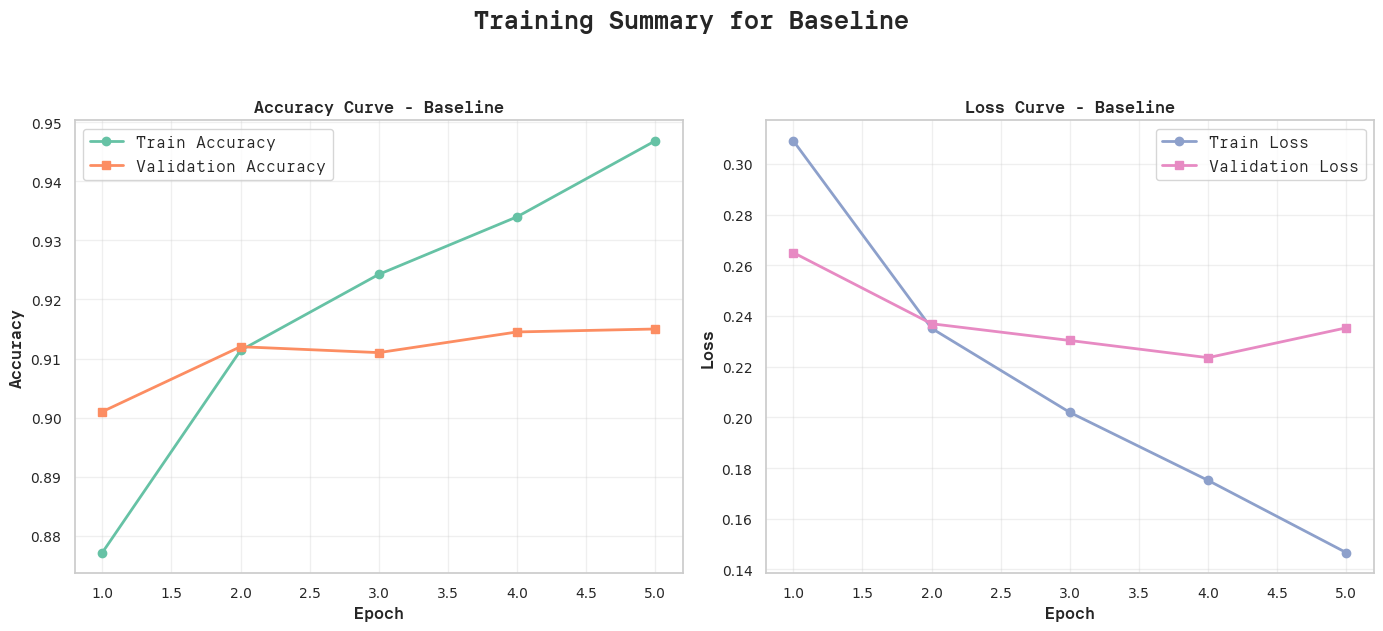

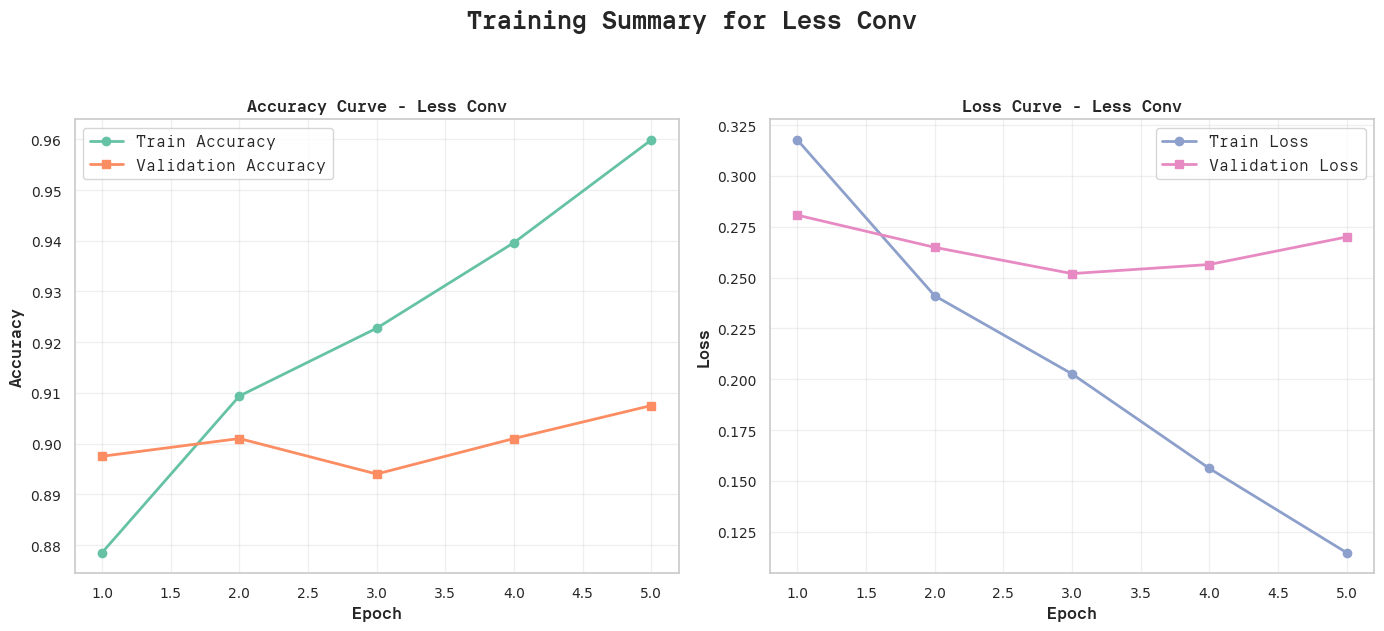

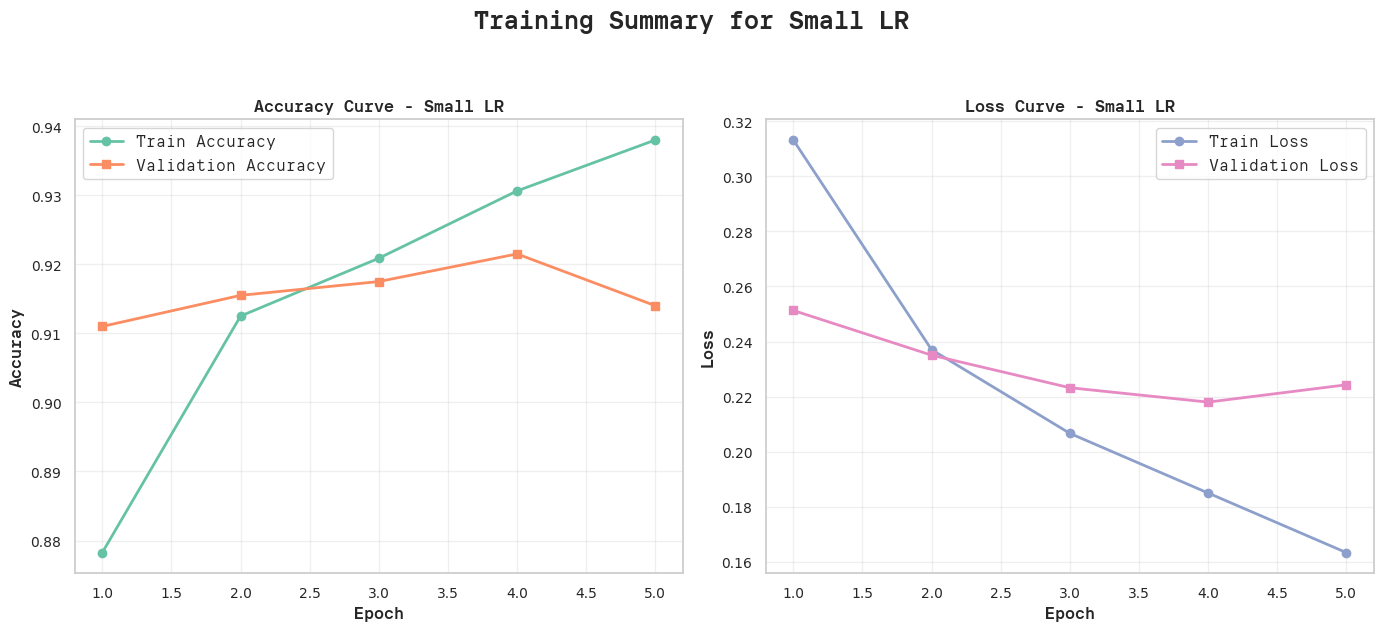

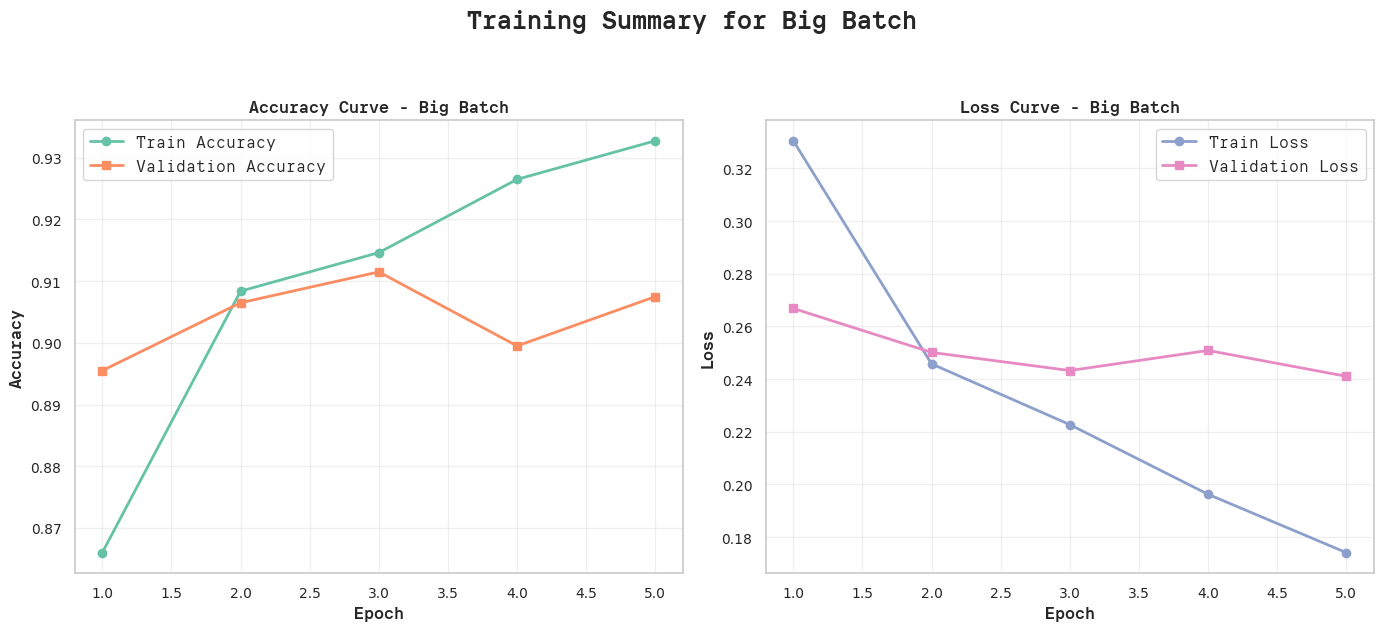

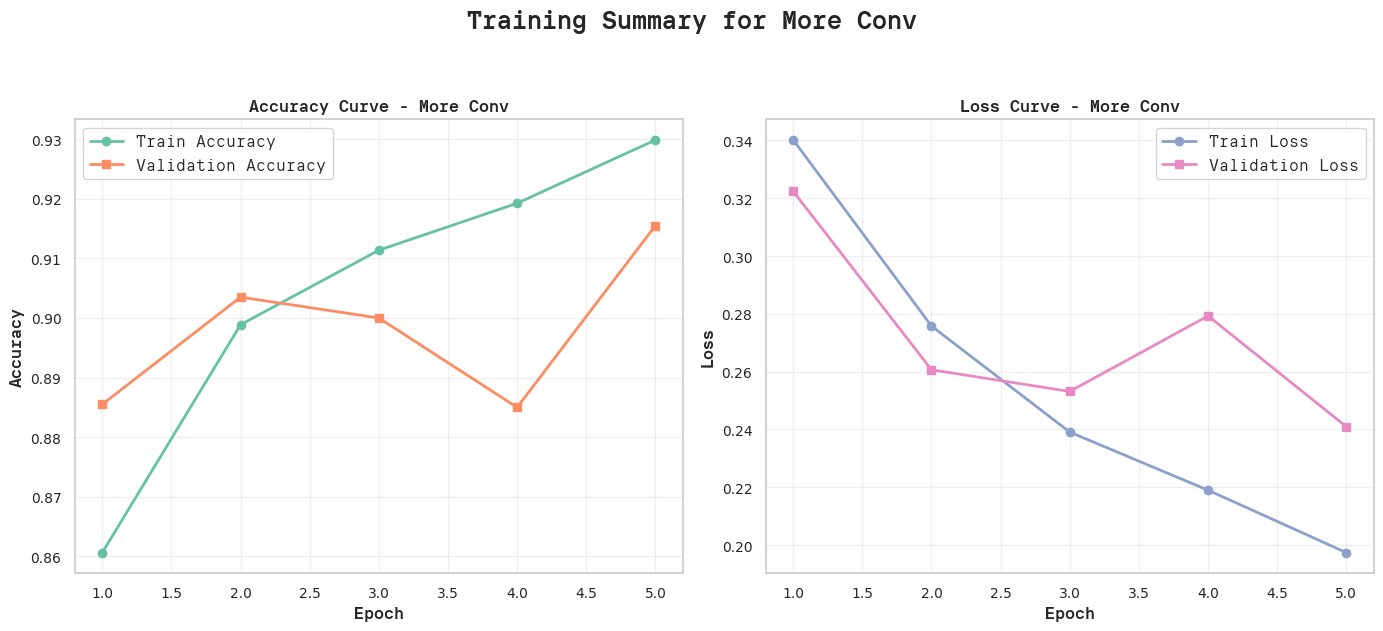

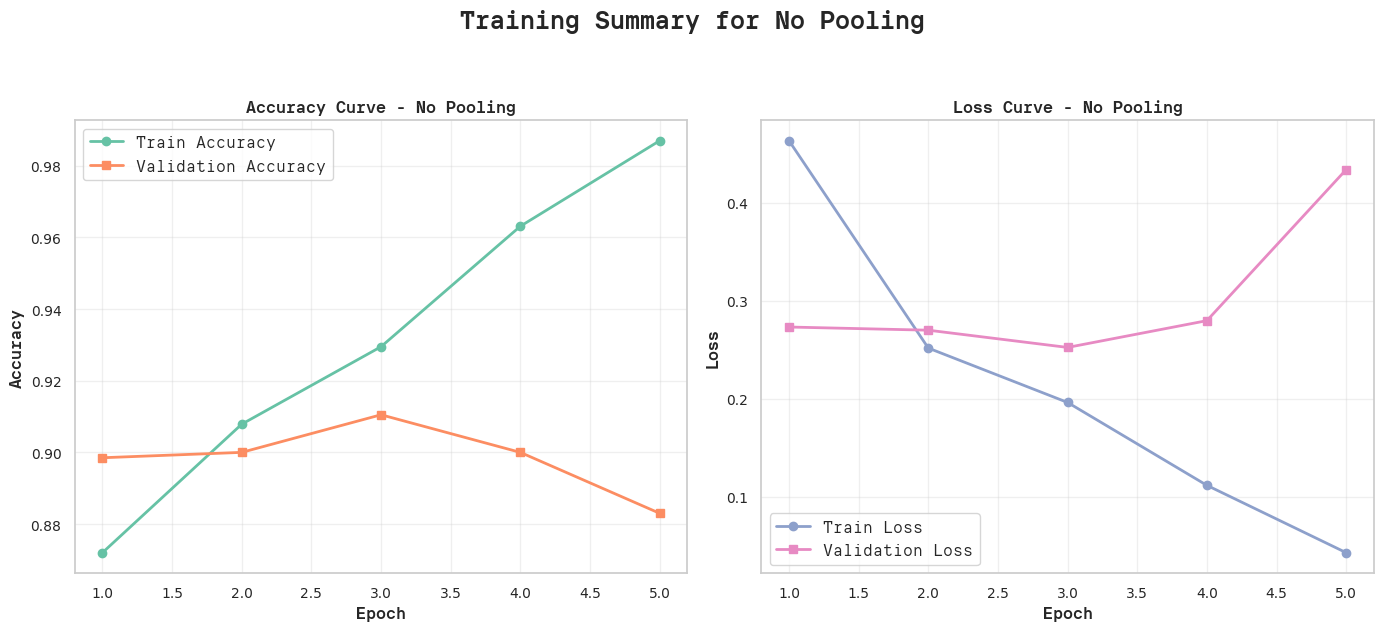

In [75]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm

custom_font_path_bold = "/kaggle/input/inter-fonts/TT Interphases Pro Mono Trial Bold.ttf"
prop = fm.FontProperties(fname=custom_font_path_bold)
custom_font_path_regular = "/kaggle/input/inter-fonts/TT Interphases Pro Mono Trial Regular.ttf"
proprg = fm.FontProperties(fname=custom_font_path_regular)
# Set Seaborn styling
sns.set(style="whitegrid")
plt.rcParams['font.family'] = prop.get_name()


colors = sns.color_palette("Set2")

# Plot accuracy and loss for each model
for result in results:
    model_id = result["ID"]
    train_acc = result["Train Acc Epochs"]
    val_acc = result["Val Acc Epochs"]
    train_loss = result["Train Loss Epochs"]
    val_loss = result["Val Loss Epochs"]
    epochs = list(range(1, len(train_acc) + 1))

    plt.figure(figsize=(14, 6))
    # plt.legend(prop=proprg)
    # Accuracy Plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_acc, label="Train Accuracy", color=colors[0], marker='o', linewidth=2)
    plt.plot(epochs, val_acc, label="Validation Accuracy", color=colors[1], marker='s', linewidth=2)
    plt.title(f"Accuracy Curve - {model_id}", fontsize=16, fontweight='bold',fontproperties=prop)
    plt.xlabel("Epoch", fontsize=12,fontproperties=prop)
    plt.ylabel("Accuracy", fontsize=12,fontproperties=prop)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=10,prop=proprg)
    plt.grid(alpha=0.3)

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label="Train Loss", color=colors[2], marker='o', linewidth=2)
    plt.plot(epochs, val_loss, label="Validation Loss", color=colors[3], marker='s', linewidth=2)
    plt.title(f"Loss Curve - {model_id}", fontsize=16, fontweight='bold',fontproperties=prop)
    plt.xlabel("Epoch", fontsize=12,fontproperties=prop)
    plt.ylabel("Loss", fontsize=12,fontproperties=prop)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.legend(fontsize=10,prop=proprg)
    plt.grid(alpha=0.3)

    plt.suptitle(f"Training Summary for {model_id}", fontsize=18, fontweight='bold',fontproperties=prop, y=1.05)
    plt.tight_layout()
    plt.show()